In [8]:
from numpy import dot, eye
from scipy.linalg import solve

def nnash(A, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2,
         beta=1.0, tol=1e-8, max_iter=1000):
    params=A, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2
    params=map(np.asarray, params)
    A, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2=params
    
    A, B1, B2=[np.sqrt(beta)*x for x in (A, B1, B2)]
    
    n=A.shape[0]
    
    if B1.ndim==1:
        k_1=1
        B1=np.reshape(B1, (n, 1))
    else:
        k_1=B1.shape[1]
     
    if B2.ndim==1:
        k_2=1
        B2=np.reshape(B2, (n, 1))
    else:
        k_2=B2.shape[1]
    
    v1=eye(k_1)
    v2=eye(k_2)
    P1=np.zeros((n, n))
    P2=np.zeros((n, n))
    F1=np.random.randn(k_1, n)
    F2=np.random.randn(k_2, n)
    
    for it in range(max_iter):
        #update
        F10=F1
        F20=F2
        
        G2=solve(dot(B2.T, P2.dot(B2))+Q2, v2)
        G1=solve(dot(B1.T, P1.dot(B1))+Q1, v1)
        H2=dot(G2, B2.T.dot(P2))
        H1=dot(G1, B1.T.dot(P1))
        
        #break up the computation of F1, F2
        F1_left=v1-dot(H1.dot(B2)+G1.dot(M1.T), H2.dot(B1)+G2.dot(M2.T))
        F1_right=H1.dot(A)+G1.dot(W1.T)-dot(H1.dot(B2)+G1.dot(M1.T), 
                                            H2.dot(A)+G2.dot(W2.T))
        F1=solve(F1_left, F1_right)
        F2=H2.dot(A)+G2.dot(W2.T)-dot(H2.dot(B1)+G2.dot(M2.T), F1)
        
        Lambda1=A-B2.dot(F2)
        Lambda2=A-B1.dot(F1)
        Pi1=R1+dot(F2.T, S1.dot(F2))
        Pi2=R2+dot(F1.T, S2.dot(F1))
        
        P1=dot(Lambda1.T, P1.dot(Lambda1))+Pi1-\
        dot(dot(Lambda1.T, P1.dot(B1))+W1-F2.T.dot(M1), F1)
        P2=dot(Lambda2.T, P2.dot(Lambda2))+Pi2-\
        dot(dot(Lambda2.T, P2.dot(B2))+W2-F1.T.dot(M2), F2)
        
        dd=np.max(np.abs(F10-F1))+np.max(np.abs(F20-F2))
        
        if dd<tol:
            break
        
    else:
        msg='no convergence: iteration limit of {0} reached in nnash'
        raise ValueError(msg.format(max_iter))
    
    return F1, F2, P1, P2

In [9]:
import numpy as np
a0=10.0
a1=2.0
beta=0.96
gamma=12.0

A=np.eye(3)
B1=np.array([[0.], [1.], [0.]])
B2=np.array([[0.], [0.], [1.]])

R1=[[0., -a0/2, 0.],
   [-a0/2., a1, a1/2.],
   [0, a1/2., 0.]]
R2=[[0., 0., -a0/2],
   [0., 0., a1/2],
   [-a0/2, a1/2., a1]]

Q1=Q2=gamma

S1=S2=W1=W2=M1=M2=0.0

F1, F2, P1, P2=nnash(A, B1, B2, R1, R2, Q1, Q2, S1, S2, W1, W2, M1, M2, beta=beta)

print("computed policies fro firm 1 and firm 2:\n")
print("F1={}".format(F1))
print("F2={}".format(F2))
print("\n")

computed policies fro firm 1 and firm 2:

F1=[[-0.66846615  0.29512482  0.07584666]]
F2=[[-0.66846615  0.07584666  0.29512482]]




In [10]:
import quantecon as qe
Lambda1=A-np.dot(B2, F2)
lq1=qe.LQ(Q1, R1, Lambda1, B1, beta=beta)
P1_ih, F1_ih, d=lq1.stationary_values()
F1_ih

array([[-0.66846611,  0.29512481,  0.07584666]])

In [11]:
np.allclose(F1, F1_ih)

True

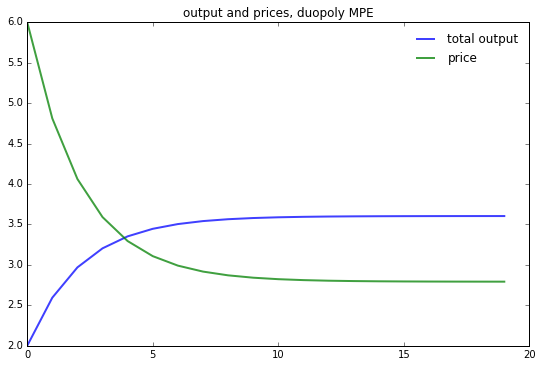

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

AF=A-B1.dot(F1)-B2.dot(F2)
n=20
x=np.empty((3, n))
x[:,0]=1, 1, 1
for t in range(n-1):
    x[:, t+1]=np.dot(AF, x[:, t])
q1=x[1, :]
q2=x[2, :]
q=q1+q2
p=a0-a1*q

fig, ax=plt.subplots(figsize=(9, 5.8))
ax.plot(q, 'b-', lw=2, alpha=0.75, label='total output')
ax.plot(p, 'g-', lw=2, alpha=0.75, label='price')
ax.set_title('output and prices, duopoly MPE')
ax.legend(frameon=False)
plt.show()

In [16]:
R=a1
Q=gamma
A=B=1
lq_alt=qe.LQ(Q, R, A, B, beta=beta)
P, F, d=lq_alt.stationary_values()
q_bar=a0/(2.0*a1)
qm=np.empty(n)
qm[0]=2
x0=qm[0]-q_bar
x=x0
for i in range(1, n):
    x=A*x-B*F*x
    qm[i]=float(x)+q_bar
pm=a0-a1*qm

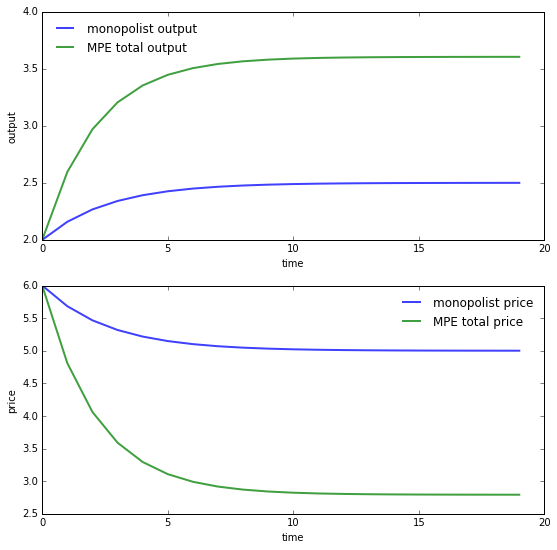

In [18]:
fig, axes=plt.subplots(2, 1, figsize=(9,9))

ax=axes[0]
ax.plot(qm, 'b-', lw=2, alpha=0.75, label='monopolist output')
ax.plot(q, 'g-', lw=2, alpha=0.75, label='MPE total output')
ax.set_ylabel("output")
ax.set_xlabel("time")
ax.set_ylim(2, 4)
ax.legend(loc='upper left', frameon=0)

ax=axes[1]
ax.plot(pm, 'b-', lw=2, alpha=0.75, label='monopolist price')
ax.plot(p, 'g-', lw=2, alpha=0.75, label='MPE total price')
ax.set_ylabel("price")
ax.set_xlabel("time")
ax.legend(loc='upper right', frameon=0)